# Breast Cancer Dataset Template
Optuna example that optimizes a neural network classifier configuration for the breast cancer dataset using Keras.

In [3]:
import optuna

Import more useful libraries

In [4]:
import pickle
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# machine learning basics
from sklearn.datasets import load_breast_cancer
# train_test_split was moved from cross_validation to model_selection in 0.18
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
BATCHSIZE = 100
# number of epochs
EPOCHS = 10

# needed to save best model so far
global best_accuracy_so_far

## The objective function for optuna to optimize the hyperparameters

In [8]:
def objective(trial):
    global best_accuracy_so_far

    # Clear clutter from previous Keras session graphs.
    clear_session()

    cancer = load_breast_cancer()

    # get features X and labels y
    X = cancer['data']
    y = cancer['target']

    # split dataset into training and validation datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y)

    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
    # save fitted scaler, because you need it later for the test dataset
    pickle.dump(scaler, open("scaler.p", "wb"))

    # Now apply the transformations to the data:
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    # create neural network
    model = Sequential()

    model.add(Input(shape=30))
    model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units=trial.suggest_int("units", 8, 24, step=4), kernel_initializer='uniform',
                    activation=trial.suggest_categorical("activation", ["relu", "linear"])))
    # Adding dropout to prevent overfitting
    model.add(Dropout(rate=trial.suggest_float("rate", 0.0, 0.1, step=0.1)))
    model.add(Dense(2, kernel_initializer='uniform', activation='sigmoid'))

    # We compile our model with a sampled learning rate.
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=learning_rate),
        metrics=["accuracy"],
    )

    # train neural network
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=False,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_val, y_val, verbose=0)

    # save best model so far to be able to use the best model later to predict with test data
    if score[1] >= best_accuracy_so_far:
        tf.keras.models.save_model(model, '{0}.mdl'.format(trial.number))
        best_accuracy_so_far = score[1]

    # return accuracy
    return score[1]

# Main Function

Use optuna to do hyperparameter optimization to find optimal neural network architecture

In [10]:
best_accuracy_so_far = -100
study = optuna.create_study(direction="maximize")
# be cautious with the number of trials: Do not use a number larger than 50
# this call starts the hyperparameter optimization process: the above define function "objective" is called with
# n_trials different hyperparameter combinations
study.optimize(objective, n_trials=5, timeout=600)

[I 2022-09-27 19:30:17,537] A new study created in memory with name: no-name-352fe1e5-9b7d-448d-8f5b-80ff94dde092


INFO:tensorflow:Assets written to: 0.mdl\assets


[I 2022-09-27 19:30:19,665] Trial 0 finished with value: 0.6153846383094788 and parameters: {'units': 16, 'activation': 'linear', 'rate': 0.0, 'learning_rate': 0.00013952458719441148}. Best is trial 0 with value: 0.6153846383094788.


INFO:tensorflow:Assets written to: 1.mdl\assets


[I 2022-09-27 19:30:21,933] Trial 1 finished with value: 1.0 and parameters: {'units': 12, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.044572326614870435}. Best is trial 1 with value: 1.0.
[I 2022-09-27 19:30:23,056] Trial 2 finished with value: 0.9650349617004395 and parameters: {'units': 12, 'activation': 'relu', 'rate': 0.0, 'learning_rate': 0.005747439672310548}. Best is trial 1 with value: 1.0.
[I 2022-09-27 19:30:24,227] Trial 3 finished with value: 0.9650349617004395 and parameters: {'units': 24, 'activation': 'relu', 'rate': 0.1, 'learning_rate': 0.053312185100345404}. Best is trial 1 with value: 1.0.
[I 2022-09-27 19:30:25,340] Trial 4 finished with value: 0.9720279574394226 and parameters: {'units': 24, 'activation': 'relu', 'rate': 0.1, 'learning_rate': 0.08434832116425706}. Best is trial 1 with value: 1.0.


In [11]:
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 5


Analyse the best model and use it to predict accuracy on test data

In [12]:
print("Best trial:")
trial = study.best_trial
print(trial)

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
FrozenTrial(number=1, values=[1.0], datetime_start=datetime.datetime(2022, 9, 27, 19, 30, 19, 666973), datetime_complete=datetime.datetime(2022, 9, 27, 19, 30, 21, 933988), params={'units': 12, 'activation': 'linear', 'rate': 0.1, 'learning_rate': 0.044572326614870435}, distributions={'units': IntDistribution(high=24, log=False, low=8, step=4), 'activation': CategoricalDistribution(choices=('relu', 'linear')), 'rate': FloatDistribution(high=0.1, log=False, low=0.0, step=0.1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)
  Value: 1.0
  Params: 
    units: 12
    activation: linear
    rate: 0.1
    learning_rate: 0.044572326614870435


Load the best model. This model was saved in the function "objective".

In [13]:
 best_model = tf.keras.models.load_model('{0}.mdl'.format(trial.number))

### Return performance of final model on new data (test data)
TODO: only load test data here, that you get a few days before the deadline.

In [14]:
cancer = load_breast_cancer()

X_test = cancer['data']
y_test = cancer['target']

scaler = pickle.load(open("scaler.p", "rb"))
# important: preprocessing of test dataset has to be the same as for the training dataset
X_test = scaler.transform(X_test)

Predicting the Test set results

In [15]:
y_pred = best_model.predict(X_test)
print(y_pred)
# create labels out of predictions
y_pred_labels = np.argmax(y_pred, axis=1)

18/18 [==============================] - 0s 941us/step
[[1.0000000e+00 6.2162892e-19]
 [1.0000000e+00 3.4075021e-10]
 [1.0000000e+00 2.1587859e-16]
 ...
 [9.9996978e-01 2.1390169e-05]
 [1.0000000e+00 4.3583032e-25]
 [1.5425551e-02 9.8565686e-01]]


Making the Confusion Matrix

In [16]:
cm = confusion_matrix(y_test, y_pred_labels)

print("Our accuracy is {}%".format(((cm[0][0] + cm[1][1]) / cm.sum()) * 100))

Our accuracy is 98.76977152899823%


Plot heatmap

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       212
           1       0.98      1.00      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.98      0.99       569
weighted avg       0.99      0.99      0.99       569



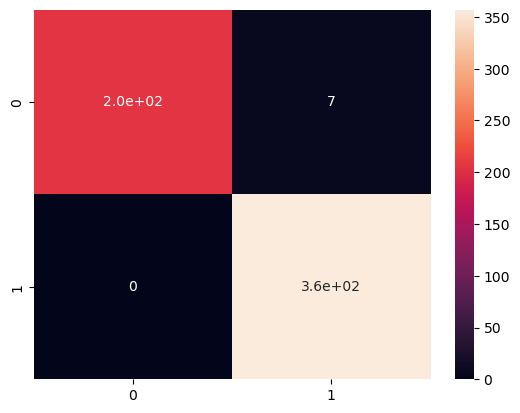

In [17]:
sns.heatmap(cm, annot=True)
plt.savefig('confmat.png')

print(classification_report(y_test, y_pred_labels))